Dataset columns: ['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Synthetic dataset saved as 'synthetic_anonymized_adult.csv'
TVD for age: 0.0411
TVD for workclass: 0.0021
TVD for education: 0.0088
Classification accuracy (synthetic data, target=income, XGBoost): 0.7774

Classification Report (synthetic data):
              precision    recall  f1-score   support

       <=50K       0.79      0.96      0.87      4942
        >50K       0.61      0.21      0.32      1571

    accuracy                           0.78      6513
   macro avg       0.70      0.58      0.59      6513
weighted avg       0.75      0.78      0.73      6513

Saved confusion matrix plot as 'confusion_matrix_synthetic.png'


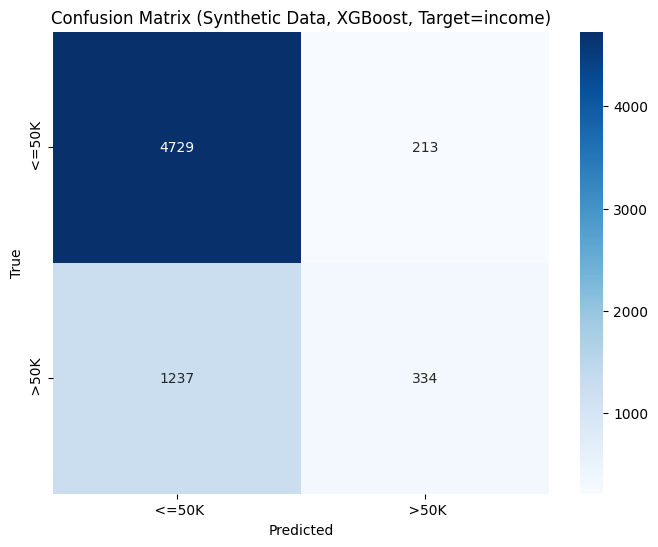

Saved ROC curve plot as 'roc_curve_synthetic.png'


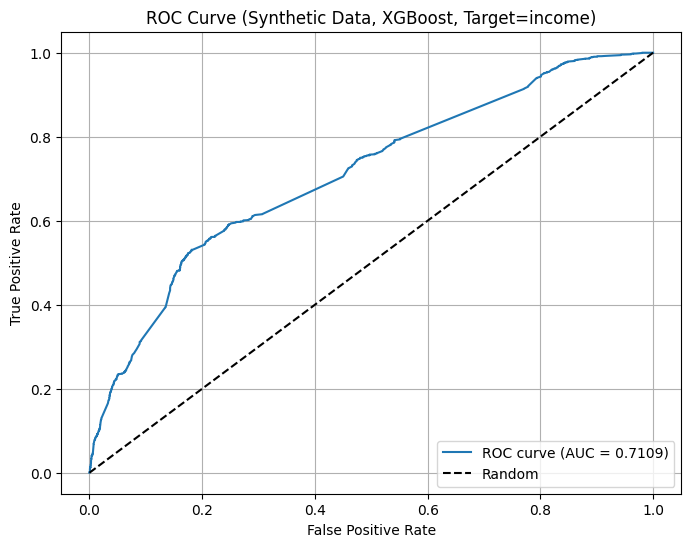


Classification accuracy (original data, target=income, XGBoost): 0.8647

Classification Report (original data):
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      4942
        >50K       0.79      0.60      0.68      1571

    accuracy                           0.86      6513
   macro avg       0.84      0.77      0.80      6513
weighted avg       0.86      0.86      0.86      6513

Saved confusion matrix plot as 'confusion_matrix_original.png'


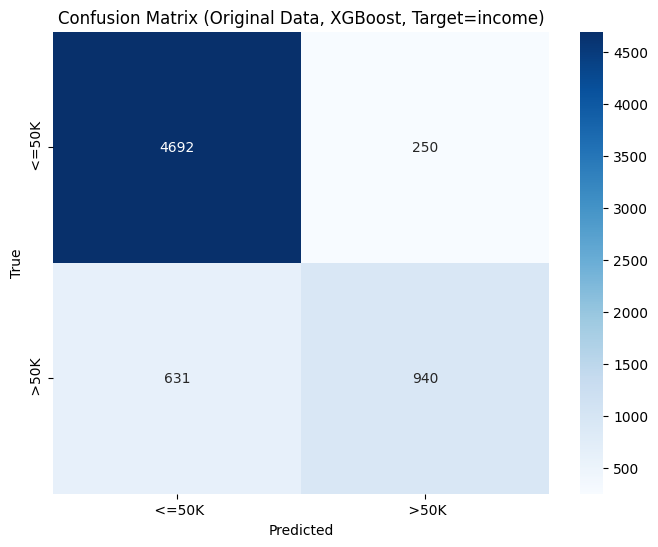

Saved ROC curve plot as 'roc_curve_original.png'


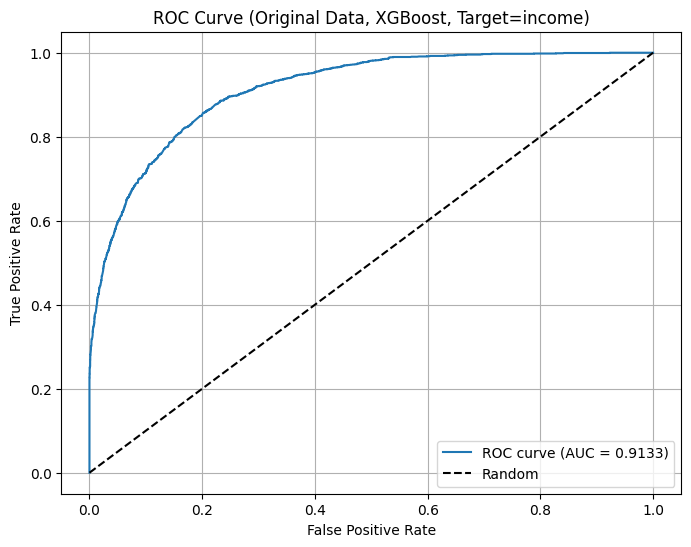

In [19]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import warnings
warnings.filterwarnings("ignore")

# DPSyn: Generate noisy marginals
def generate_noisy_marginals(data, columns, k, epsilon):
    marginals = {}
    combs = list(itertools.combinations(columns, k))
    np.random.shuffle(combs)
    combs = combs[:min(len(combs), 10)]
    sensitivity = 1.0
    for comb in combs:
        try:
            counts = data[list(comb)].value_counts().to_dict()
            noisy_counts = {}
            for key, count in counts.items():
                noise = np.random.laplace(0, sensitivity / epsilon)
                noisy_counts[key] = max(0, count + noise)
            marginals[comb] = noisy_counts
        except Exception as e:
            print(f"Error computing marginal for {comb}: {e}")
    return marginals

# DPSyn: Make marginals consistent (simplified PriView)
def make_consistent(marginals, data, columns):
    synthetic_data = data.copy()
    for comb, noisy_counts in marginals.items():
        try:
            total = sum(noisy_counts.values())
            if total == 0:
                continue
            probs = {k: v / total for k, v in noisy_counts.items()}
            keys = list(probs.keys())
            prob_values = [probs[k] for k in keys]
            sample_size = len(data)
            sampled_indices = np.random.choice(len(keys), size=sample_size, p=prob_values)
            sampled_keys = [keys[i] for i in sampled_indices]
            for i, key in enumerate(sampled_keys):
                for j, col in enumerate(comb):
                    synthetic_data.at[i, col] = key[j]
        except Exception as e:
            print(f"Error applying marginal for {comb}: {e}")
    return synthetic_data

# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename)
    print(f"Saved confusion matrix plot as '{filename}'")
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, n_classes, classes, title, filename):
    plt.figure(figsize=(8, 6))
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
        auc = roc_auc_score(y_true, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    else:
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, i], pos_label=i)
            auc = roc_auc_score(y_true == i, y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {auc:.4f})')
        # Macro-average AUC
        auc_macro = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        plt.plot([], [], ' ', label=f'Macro-average AUC = {auc_macro:.4f}')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(filename)
    print(f"Saved ROC curve plot as '{filename}'")
    plt.show()

# Load HW1 dataset with correct column names
data_path = r"c:\Users\USER\Documents\NTUST\2nd Sem\Data Privacy\adult\adult.data"
adult_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
try:
    data = pd.read_csv(data_path, names=adult_columns, skiprows=0)
except FileNotFoundError:
    print(f"Error: Dataset not found at {data_path}")
    exit(1)

# Drop fnlwgt column
if 'fnlwgt' in data.columns:
    data = data.drop('fnlwgt', axis=1)
    adult_columns.remove('fnlwgt')

# Verify and print columns
columns = data.columns
print("Dataset columns:", list(columns))

# Preprocess: Handle k-anonymized data
data = data.fillna('missing')
data = data.astype(str)

# Parameters
epsilon_total = 1.0
num_marginals = 10
epsilon_per_marginal = epsilon_total / num_marginals if num_marginals > 0 else epsilon_total

# Step 1 & 2: Generate noisy marginals
marginals = generate_noisy_marginals(data, columns, k=2, epsilon=epsilon_per_marginal)

# Step 3: Make marginals consistent and generate synthetic data
synthetic_data = make_consistent(marginals, data, columns)

# Save synthetic dataset
output_path = "synthetic_anonymized_adult.csv"
synthetic_data.to_csv(output_path, index=False)
print(f"Synthetic dataset saved as '{output_path}'")

# Evaluation: Total Variation Distance (TVD)
def tvd(original, synthetic, column):
    try:
        orig_counts = original[column].value_counts(normalize=True)
        synth_counts = synthetic[column].value_counts(normalize=True)
        common_idx = orig_counts.index.intersection(synth_counts.index)
        return 0.5 * np.sum(np.abs(orig_counts[common_idx] - synth_counts[common_idx]))
    except Exception as e:
        print(f"Error computing TVD for {column}: {e}")
        return None

# Compute TVD for selected columns
tvd_results = {}
eval_columns = ['age', 'workclass', 'education']
for col in eval_columns:
    if col in columns:
        tvd_value = tvd(data, synthetic_data, col)
        if tvd_value is not None:
            tvd_results[col] = tvd_value
            print(f"TVD for {col}: {tvd_value:.4f}")

# Evaluation: Classification accuracy with XGBoost
target_column = 'income' if 'income' in columns else 'marital-status'
if target_column:
    try:
        X = data.drop(target_column, axis=1)
        y = data[target_column]
        X_synthetic = synthetic_data.drop(target_column, axis=1)
        y_synthetic = synthetic_data[target_column]

        # Encode categorical variables
        le = LabelEncoder()
        y = le.fit_transform(y)
        y_synthetic = le.transform(y_synthetic)
        X = pd.get_dummies(X)
        X_synthetic = pd.get_dummies(X_synthetic)

        # Clean feature names for XGBoost
        X.columns = [re.sub(r'[<>$$  $$,]', '_', col) for col in X.columns]
        X_synthetic = X_synthetic.reindex(columns=X.columns, fill_value=0)

        # Split original data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train on synthetic data, test on original
        clf = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            objective='binary:logistic' if data[target_column].nunique() == 2 else 'multi:softmax',
            eval_metric='logloss' if data[target_column].nunique() == 2 else 'mlogloss',
            random_state=42
        )
        clf.fit(X_synthetic, y_synthetic)
        y_pred_synthetic = clf.predict(X_test)
        accuracy_synthetic = clf.score(X_test, y_test)
        print(f"Classification accuracy (synthetic data, target={target_column}, XGBoost): {accuracy_synthetic:.4f}")
        print("\nClassification Report (synthetic data):")
        print(classification_report(y_test, y_pred_synthetic, target_names=le.classes_))
        
        # Plot confusion matrix for synthetic data
        plot_confusion_matrix(
            y_test, y_pred_synthetic, le.classes_,
            "Confusion Matrix (Synthetic Data, XGBoost, Target=" + target_column + ")",
            "confusion_matrix_synthetic.png"
        )

        # Plot ROC curve for synthetic data
        y_pred_proba_synthetic = clf.predict_proba(X_test)
        plot_roc_curve(
            y_test, y_pred_proba_synthetic, data[target_column].nunique(), le.classes_,
            "ROC Curve (Synthetic Data, XGBoost, Target=" + target_column + ")",
            "roc_curve_synthetic.png"
        )

        # Baseline: Train and test on original
        clf.fit(X_train, y_train)
        y_pred_original = clf.predict(X_test)
        accuracy_original = clf.score(X_test, y_test)
        print(f"\nClassification accuracy (original data, target={target_column}, XGBoost): {accuracy_original:.4f}")
        print("\nClassification Report (original data):")
        print(classification_report(y_test, y_pred_original, target_names=le.classes_))
        
        # Plot confusion matrix for original data
        plot_confusion_matrix(
            y_test, y_pred_original, le.classes_,
            "Confusion Matrix (Original Data, XGBoost, Target=" + target_column + ")",
            "confusion_matrix_original.png"
        )

        # Plot ROC curve for original data
        y_pred_proba_original = clf.predict_proba(X_test)
        plot_roc_curve(
            y_test, y_pred_proba_original, data[target_column].nunique(), le.classes_,
            "ROC Curve (Original Data, XGBoost, Target=" + target_column + ")",
            "roc_curve_original.png"
        )

    except Exception as e:
        print(f"Error in classification evaluation: {e}")
else:
    print("No suitable target column found for classification.")